In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import numpy as np
from datetime import timedelta, datetime

# Data: what happened so far?

**Selection**: what are relevant characteristica?

**Cleaning**: 
- missing values in MODEL: 2
    - using the historical records of that VIN fill in the missing MODEL values
- engineer new feature: MAKE + MODEL + MODEL_YEAR
    - unique MAKE_MODEL_YEAR: 11684
    - total records: 187503
- drop: MODEL, MAKE, ZIP_CODE
- if a vehicle has multiple records from the same date, keep first record
    - records where vehicles got tested more than 1 time a day: 4046
    - after removing repeated tests from same day
        - total number of records: 187503 > 183457 
        - P: 173762 > 170120
        - F: 13741 > 13337
        - data range: 2013-01-01/2020-12-31 
- engineer feature: VEHICLE_AGE
- extract month, weekday, hour from TEST_SDATE: pause!!!
    - testing time ~ testing outcome??   
- drop TEST_SDATE
- map to numeric: TEST_TYPE:{'I':0, 'A':1}, TRANS_TYPE:{'A':0, 'M':1}
- drop VEHICLE_TYPE
    - near 1000 MAKE_MODEL_YEARs had more than 1 VEHICLE_TYPE 
    - it's not clear how vehicle types were defined
- extract CYL_9, CYL_12, CYL_R from CYL ??
    - share of fail is higher when CYL is 9, 12 and R
    - not sure if I should combine them
- drop FUEL_TYPE (FUEL_TYPE L only has 4 records and all are Pass)
    - more than 95% of the tests have FUEL_TYPE G
- 0 in GVWR: 11577 (P: 11090, F: 487)
    - set 0 to np.nan
    - fill in missing values using other records having the same VIN
        - left missing values: 7963 (P: 7564, F: 399)
- 0 in ODOMETER: 875
    - P:    746
    - F:    129

In [2]:
# get original data
data_src = Path("data/sample201320.csv")
df_full = pd.read_csv(data_src, low_memory=False, sep=',')
df_full.shape
df_full['OVERALL_RESULT'].value_counts(normalize=True) * 100

P    89.887745
F     7.108272
A     3.002949
O     0.001035
Name: OVERALL_RESULT, dtype: float64

In [3]:
# get clean data
data_src = Path("data/clean_data_20210505.csv")
df_clean = pd.read_csv(data_src, low_memory=False, sep=',')
df_clean.shape
df_clean['RESULT'].value_counts(normalize=True) * 100

1    92.730177
0     7.269823
Name: RESULT, dtype: float64

In [4]:
# additionally dropping all that don't have any odometer values
df = df_clean[df_clean['ODOMETER'].isna() != 1]
df['RESULT'].value_counts(normalize=True) * 100

1    92.76599
0     7.23401
Name: RESULT, dtype: float64

# What are the characteristica?

In [27]:
list(df.columns)

['RecordID',
 'RESULT',
 'TEST_TYPE',
 'MODEL_YEAR',
 'GVWR',
 'ENGINE_SIZE',
 'TRANS_TYPE',
 'ODOMETER',
 'MAKE_MODEL_YEAR',
 'VEHICLE_AGE',
 'CYL_9',
 'CYL_10',
 'CYL_R']

## TEST_TYPE
* Initial
* Retest

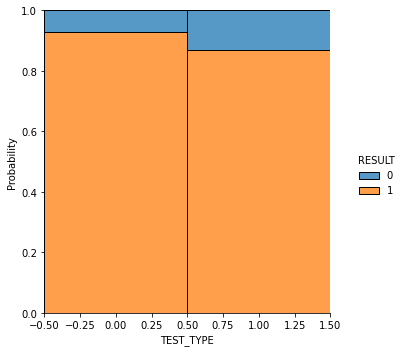

In [6]:
sns.displot(data=df, x='TEST_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')

## MODEL_YEAR

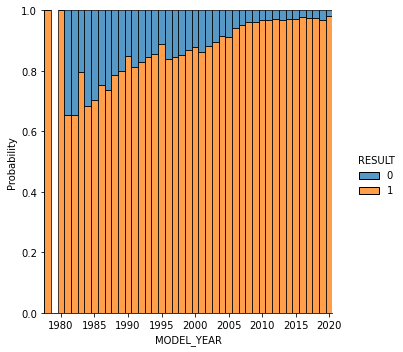

In [7]:
sns.displot(data=df, x='MODEL_YEAR', hue='RESULT', multiple='fill', discrete=True, stat='probability')

## GVWR

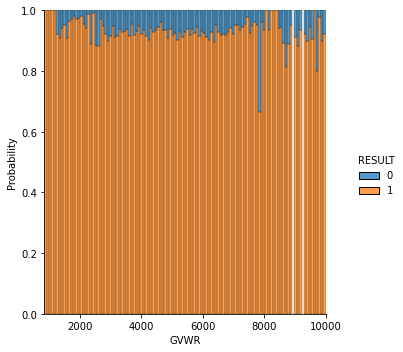

In [9]:
sns.displot(data=df, x='GVWR', hue='RESULT', multiple='fill', discrete=False, stat='probability')

<AxesSubplot:xlabel='RESULT', ylabel='GVWR'>

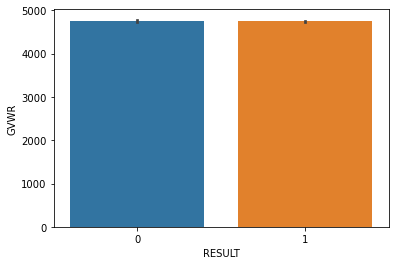

In [25]:
sns.barplot(x='RESULT', y='GVWR', data=df)

## ENGINE_SIZE

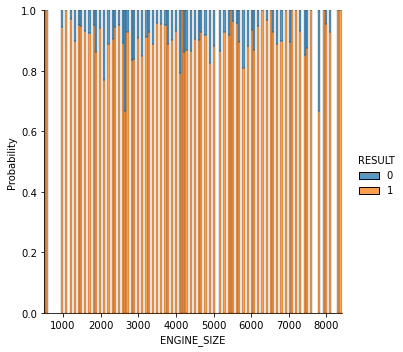

In [10]:
sns.displot(data=df, x='ENGINE_SIZE', hue='RESULT', multiple='fill', discrete=False, stat='probability')

<AxesSubplot:xlabel='RESULT', ylabel='ENGINE_SIZE'>

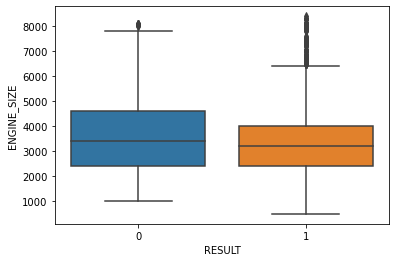

In [37]:
sns.boxplot(data=df, y='ENGINE_SIZE', x='RESULT')

## TRANS_TYPE

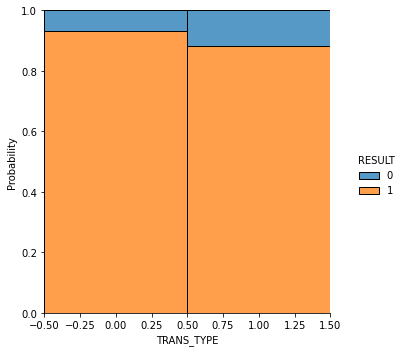

In [11]:
sns.displot(data=df, x='TRANS_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')

## ODOMETER

<AxesSubplot:xlabel='RESULT', ylabel='ODOMETER'>

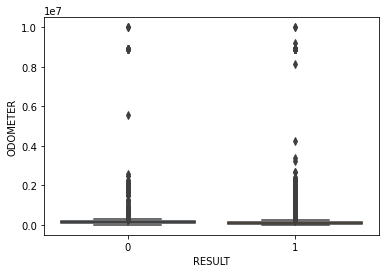

In [36]:
sns.boxplot(data=df, y='ODOMETER', x='RESULT')

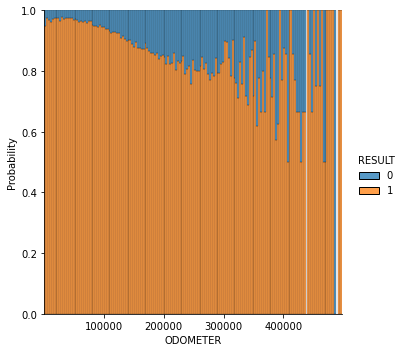

In [15]:
sns.displot(data=df[df['ODOMETER'] < 500000], x='ODOMETER', hue='RESULT', multiple='fill', discrete=False, stat='probability')

<AxesSubplot:xlabel='RESULT', ylabel='ODOMETER'>

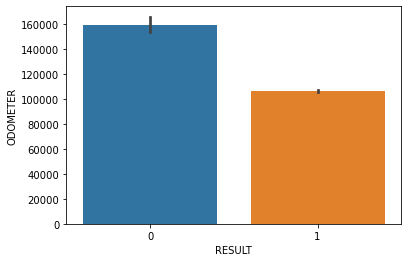

In [39]:
sns.barplot(x='RESULT', y='ODOMETER', data=df)

## MAKE_MODEL_YEAR
* What do we want to do with this?

## VEHICLE_AGE

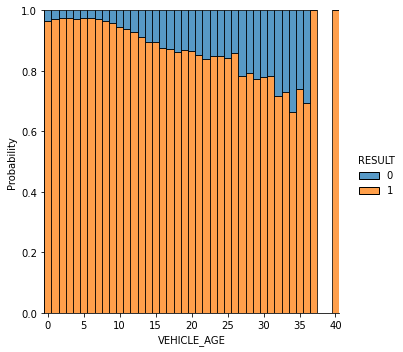

In [18]:
sns.displot(data=df, x='VEHICLE_AGE', hue='RESULT', multiple='fill', discrete=True, stat='probability')

<AxesSubplot:xlabel='RESULT', ylabel='VEHICLE_AGE'>

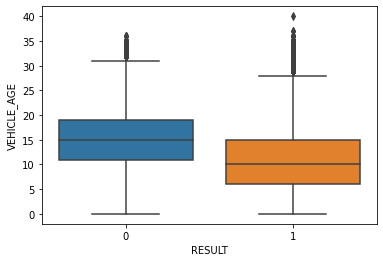

In [40]:
sns.boxplot(x='RESULT', y='VEHICLE_AGE', data=df)

# Do any characteristics relate to one another?

## Correlation of our metric variables

<AxesSubplot:>

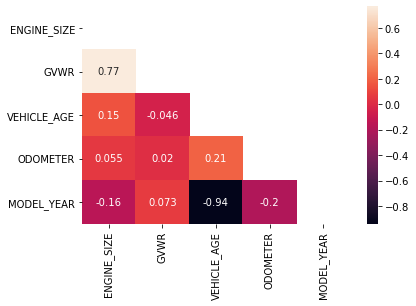

In [35]:
# correlation stuff
cols = ['ENGINE_SIZE', 'GVWR', 'VEHICLE_AGE', 'ODOMETER', 'MODEL_YEAR']
df_cor = df[cols].copy()
# show some correlations
matrix = np.triu(df_cor.corr())
sns.heatmap(df_cor.corr(), annot=True, mask=matrix)